In [ ]:
# The problem is Time Series
# in which the number of demands for rides in a certain region is changing over our time bins that we define
## the paper that I used is https://medium.datadriveninvestor.com/ola-lyft-rapido-gojek-grab-and-uber-bikes-ride-demand-forecasting-data-science-in-cead02e44201

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# loading data 
# I assumed that the all Lats and lngs are in valid ranges in Tallinn
B_data=pd.read_csv("robotex5.csv",sep=',')#header=0,
B_data.columns

Index(['start_time', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'ride_value'],
      dtype='object')

In [325]:
B_data.head()

,start_time,start_lat,start_lng,end_lat,end_lng,ride_value
0,2022-03-06 15:02:39.329452000,59.407910,24.689836,59.513027,24.831630,3.51825
1,2022-03-10 11:15:55.177526000,59.441650,24.762712,59.426450,24.783076,0.50750
2,2022-03-06 14:23:33.893257000,59.435404,24.749795,59.431901,24.761588,0.19025
3,2022-03-03 09:11:59.104192000,59.406920,24.659006,59.381093,24.641652,0.75600
4,2022-03-06 00:13:01.290346000,59.434940,24.753641,59.489203,24.876170,2.27100


In [240]:
# the results shows there are not null values since the Non-Null Counts are equal to the number of the rows
B_data.info()
B_data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627210 entries, 0 to 627209
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   start_time  627210 non-null  object 
 1   start_lat   627210 non-null  float64
 2   start_lng   627210 non-null  float64
 3   end_lat     627210 non-null  float64
 4   end_lng     627210 non-null  float64
 5   ride_value  627210 non-null  float64
dtypes: float64(5), object(1)
memory usage: 28.7+ MB


(627210, 6)

In [333]:
#The timestamps are converted to unix so as to get duration(trip-time) & speed also pickup-times in unix are used while binning 
# in out data we have time in the formate "YYYY-MM-DD HH:MM:SS" we convert this sting to python time format and then into unix time stamp
# 1646085600
# unix time: https://www.unixtimestamp.com/
import datetime 
import time #Convert to unix time
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s.split('.')[0], "%Y-%m-%d %H:%M:%S").timetuple())
#start_time to unix time
start_time = [convert_to_unix(x) for x in B_data['start_time'].values]
B_frame = B_data [[ 'start_lat', 'start_lng', 'end_lat', 'end_lng','ride_value']]
 #append start of trips to a new dataframe
B_frame ['start_time'] = start_time
B_frame.head()

,start_lat,start_lng,end_lat,end_lng,ride_value,start_time
0,59.407910,24.689836,59.513027,24.831630,3.51825,1.646572e+09
1,59.441650,24.762712,59.426450,24.783076,0.50750,1.646904e+09
2,59.435404,24.749795,59.431901,24.761588,0.19025,1.646569e+09
3,59.406920,24.659006,59.381093,24.641652,0.75600,1.646292e+09
4,59.434940,24.753641,59.489203,24.876170,2.27100,1.646518e+09


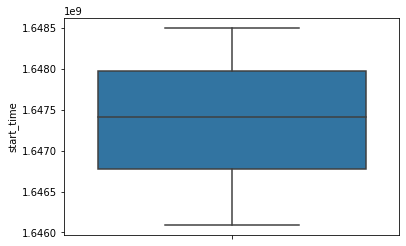

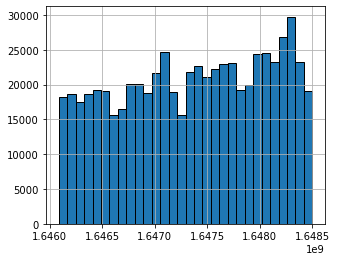

In [337]:
# the skewed box plot shows no presence of outliers 
sns.boxplot(y='start_time', data =B_frame)
plt.show()
import matplotlib.pyplot as plt
B_frame['start_time'].hist(figsize=(5, 4), bins=30, edgecolor="black")
plt.show()

In [334]:
## Here the trip distance is claculated based on Euclidean distance and added to the frame
import math
Temp1=((B_frame['start_lat']- B_frame['end_lat'])**2+(B_frame['start_lng']- B_frame['end_lng'])**2)
Temp2=[math.sqrt(x) for x in Temp1 ]
B_frame['trip_distance']=Temp2
B_frame.head()

,start_lat,start_lng,end_lat,end_lng,ride_value,start_time,trip_distance
0,59.407910,24.689836,59.513027,24.831630,3.51825,1.646572e+09,0.176508
1,59.441650,24.762712,59.426450,24.783076,0.50750,1.646904e+09,0.025411
2,59.435404,24.749795,59.431901,24.761588,0.19025,1.646569e+09,0.012302
3,59.406920,24.659006,59.381093,24.641652,0.75600,1.646292e+09,0.031116
4,59.434940,24.753641,59.489203,24.876170,2.27100,1.646518e+09,0.134007


In [144]:
## Data-preperation, Clustering/Segmentation
#trying different cluster sizes to choose the right K in K-means
# this lib is used while we calculate the stight line distance between two (lat,lon) pairs in miles
import gpxpy.geo #Get the haversine distance

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
coords = B_frame[['start_lat', 'start_lng']].values
neighbours=[]

def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of ",cluster_len,"\nAvg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less2)/len(less2)), "\nAvg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    B_frame['start_cluster'] = kmeans.predict(B_frame[['start_lat', 'start_lng']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

# we need to choose number of clusters so that, there are more number of cluster regions 
#that are close to any cluster center
# and make sure that the minimum inter cluster should not be very less
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)  

On choosing a cluster size of  10 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  0.7557213820943519 
---
On choosing a cluster size of  20 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 3.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 17.0 
Min inter-cluster distance =  0.43678461981222033 
---
On choosing a cluster size of  30 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 25.0 
Min inter-cluster distance =  0.43609388678701305 
---
On choosing a cluster size of  40 
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 7.0 
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 33.0 
Min inter-cluster distanc

In [463]:
# if check for the 50 clusters you can observe that there are two clusters with only 0.34 miles apart from each other
# so we choose 40 clusters for solve the further problem

# Getting 40 clusters using the kmeans 
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000,random_state=0).fit(coords)
B_frame['start_cluster'] = kmeans.predict(B_frame[['start_lat', 'start_lng']])

In [464]:
# Plotting the cluster centers on OSM
import folium #open street map
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

map_osm = folium.Map(location=[59.35515045692697, 24.6109297717266], tiles='Stamen Toner')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0],cluster_centers[i][1])), popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

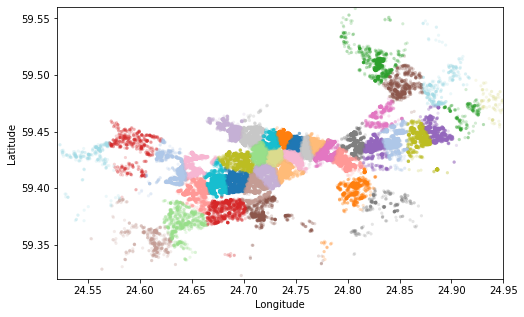

In [465]:
#Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (24.52, 24.95)
    city_lat_border = (59.32, 59.56)
    fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(8,5))
    ax.scatter(frame.start_lng.values[:100000], frame.start_lat.values[:100000], s=10, lw=0,
               c=frame.start_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(B_frame)

In [466]:
# Time-binning, the number of bin for 10 minutes bins are 24*31*60/10 = 4464
#Refer:https://www.unixtimestamp.com/
# unix time stamp for 2022-03-01 is 1646085600

def add_pickup_bins(frame):
    unix_pickup_times=[i for i in frame['start_time'].values]
    # unix time stamp for 2022-03-01 is 1646085600
    tenminutewise_binned_unix_pickup_times=[(int((i-1646085600)/600)) for i in unix_pickup_times] 
    frame['start_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [467]:
# clustering, making start bins and grouping by start cluster and start bins
## here in B_3_2022_groupby dataframe the trip_distance represents the number of pickups that are happened in each bin
B_frame['start_cluster'] = kmeans.predict(B_frame[['start_lat', 'start_lng']])
B_3_2022_frame = add_pickup_bins(B_frame)
B_3_2022_groupby = B_3_2022_frame[['start_cluster','start_bins','trip_distance']].groupby(['start_cluster','start_bins']).count() 

In [491]:
# here the trip_distance represents the number of pickups that are happend in that particular 10min intravel
# this data frame has two indices
# primary index: start_cluster (cluster number)
# secondary index : start_bins (we devid whole months time into 10min intravels 24*31*60/10 =4464bins)
B_3_2022_groupby.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 128498 entries, (0, 0) to (39, 4025)
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   trip_distance  128498 non-null  int64
dtypes: int64(1)
memory usage: 1.4 MB


In [487]:
# it shows the correlation btw start_cluster and ride_value that we can use it later 
# for AB-test like sum of ride_value per cluster
# B_3_2022_groupby.head()
# B_3_2022_frame.info()
corr_matix=B_3_2022_frame.corr()
corr_matix['start_cluster'].sort_values(ascending=False)

start_cluster    1.000000
end_lng          0.003965
start_lat        0.003468
end_lat          0.001984
start_bins      -0.000115
start_time      -0.000115
ride_value      -0.002769
trip_distance   -0.003091
start_lng       -0.037178
Name: start_cluster, dtype: float64

In [492]:
# Investigating Null bins, for doing so, we first obtain the bins with values
# Gets the unique bins where pickup values are present for each each region
# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some start bins that doesnt have any pickups
num_cluster=40
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,num_cluster):
        new = frame[frame['start_cluster'] == i]
        list_unq = list(set(new['start_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

# we get all indices of 10min intravels in which at least one picku p got happened
B_3_2022_frame_unique = return_unq_pickup_bins(B_3_2022_frame)

In [493]:
# for each cluster number of 10min intravels with 0 pickups
for i in range(40):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(B_3_2022_frame_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  446
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  549
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  921
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  1049
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  1387
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  516
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  701
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  535
---

In [494]:
# For simplicity we replace mising values with zero, we could use some averaging
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickups that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,40):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

#Filling Missing values of March 2022 with 0
# here in B_3_2022_groupby dataframe the trip_distance represents the number of pickups that are happened
B_3_2022_fill = fill_missing(B_3_2022_groupby['trip_distance'].values,B_3_2022_frame_unique)

# number of 10min indices for March 2020= 24*31*60/10 = 4464
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the B_3_2022_fill)
print("number of 10min intravels among all the clusters ",len(B_3_2022_fill))

number of 10min intravels among all the clusters  178560


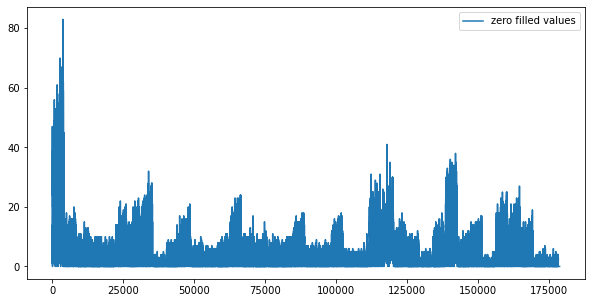

In [495]:
# sample plot that shows the number of pickups with filling missing values
plt.figure(figsize=(10,5))
plt.plot(B_3_2022_fill, label="zero filled values")
plt.legend()
plt.show()

In [496]:
# Making list of all the values of pickup data in every bin for a period of 1 month and storing them region-wise 
regions_cum = []

# number of 10min indices for March 2022= 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464 values which represents the number of pickups 
# that are happened on March in 2022

for i in range(0,40):
    regions_cum.append(B_3_2022_fill[4464*i:4464*(i+1)])

print(len(regions_cum))
print(len(regions_cum[0]))

40
4464


In [497]:
#Train-Test Split

# Preparing data to be split into train and test, The below prepares data in cumulative form which will be later split into test and train
# number of 10min indices for March 2022= 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464 values which represents the number of pickups 
# that are happened for March 2022

# we take number of pickups that are happened in last 5 10min intravels
number_of_time_stamps = 5

# output varaible (for simplicity I consider the pure pickup demand as label)
# it is list of lists
# it will contain number of pickups 4459 for each cluster
output = []


# tsne_lat will contain 4464-5=4459 times the cluster number
# Ex: [[cent_lat 4459times],[cent_lat 4459times], [cent_lat 4459times].... 40 lists]
# it is list of lists
tsne_lat = []


# tsne_lon will contain 4464-5=13099 times logitude of cluster center for every cluster
# Ex: [[cent_long 4459times],[cent_long 4459times], [cent_long 4459times].... 40 lists]
# it is list of lists
tsne_lon = []

# its an numbpy array, of shape (178360, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(0,40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*4459)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*4459)
    # our prediction start from 5th 10min intravel since we need to have number of pickups that are happened in last 5 pickup bins
    # regions_cum is a list of lists [[x1,x2,x3..x4464], [x1,x2,x3..x4464], [x1,x2,x3..x4464], [x1,x2,x3..x4464], [x1,x2,x3..x4464], .. 40 lsits]
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
tsne_feature = tsne_feature[1:]
tsne_feature.shape

(178360, 5)

In [753]:
np.array(output).shape

(40, 4459)

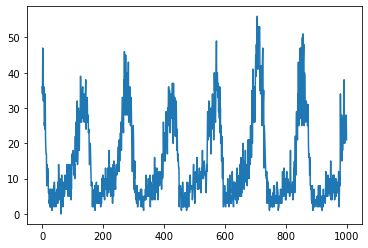

In [758]:
# it shows the output has seasonality and trend
plt.plot(output[0][:1000]) # the seanality is perday
plt.show()

In [498]:
# Getting the predictions of exponential moving averages to be used as a feature in cumulative form

# upto now we computed 7 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 4. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 5. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 6. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 7. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# the exponential weighted moving avarage adds the exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 4464 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x4464], [x5,x6,x7..x4464], [x5,x6,x7..x4464], [x5,x6,x7..x4464], [x5,x6,x7..x4464], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,40):
    for i in range(0,4464):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [499]:
# train, test split : 70% 30% split
# Before we start predictions using the tree based regression models we take 1 months of 2022 pickup data 
# and split it such that for every region we have 70% data in train and 30% in test,
# ordered date-wise for every region
print("size of train data :", int(4459*0.7))
print("size of test data :", int(4459*0.3))

size of train data : 3121
size of test data : 1337


In [500]:
# extracting first 3121 timestamp values i.e 70% of 4459 (total timestamps) for our training data
train_features =  [tsne_feature[i*4459:(4459*i+3121)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(4459*(i))+3121:4459*(i+1)] for i in range(0,40)]

In [501]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 40 Number of data points in trian data 3121 Each data point contains 5 features
Number of data clusters 40 Number of data points in test data 1338 Each data point contains 5 features


In [502]:
# extracting first 3121 timestamp values i.e 70% of 4459 (total timestamps) for our training data
tsne_train_flat_lat = [i[:3121] for i in tsne_lat]
tsne_train_flat_lon = [i[:3121] for i in tsne_lon]
tsne_train_flat_weekday = [i[:3121] for i in tsne_weekday]
tsne_train_flat_output = [i[:3121] for i in output]
tsne_train_flat_exp_avg = [i[:3121] for i in predict_list] ####

In [503]:
# extracting the rest of the timestamp values i.e 30% of 4459 (total timestamps) for our test data
tsne_test_flat_lat = [i[3121:] for i in tsne_lat]
tsne_test_flat_lon = [i[3121:] for i in tsne_lon]
tsne_test_flat_weekday = [i[3121:] for i in tsne_weekday]
tsne_test_flat_output = [i[3121:] for i in output]
tsne_test_flat_exp_avg = [i[3121:] for i in predict_list]####

In [504]:
# the above contains values in the form of list of lists (i.e. list of values of each region), here we make all of them in one list
train_new_features = []
for i in range(0,40):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,40):
    test_new_features.extend(test_features[i])

In [505]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])####

In [507]:
# converting lists of lists into sinle list i.e flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [508]:
# Preparing the data frame for our train data
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['exp_avg'] = tsne_train_exp_avg

print(df_train.shape)

(124840, 8)


In [509]:
# Preparing the data frame for our train data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['exp_avg'] = tsne_test_exp_avg###
print(df_test.shape)

(53520, 8)


In [543]:
df_test.head()
df_test2=df_test.drop("exp_avg", axis=1, inplace=False)
df_test2.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,lat,lon
0,16,18,13,9,13,59.437408,24.74931
1,18,13,9,13,20,59.437408,24.74931
2,13,9,13,20,14,59.437408,24.74931
3,9,13,20,14,16,59.437408,24.74931
4,13,20,14,16,16,59.437408,24.74931


In [511]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [512]:
# Using Linear Regression
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------

from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, tsne_train_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

In [513]:
#Using Random Forest Regressor
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [517]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [518]:
#feature importances based on analysis using random forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'exp_avg'], dtype='object')
[0.07104198 0.09532656 0.13302071 0.16215421 0.18791053 0.02181424
 0.03435688 0.29437488]


In [519]:
# Using XgBoost Regressor
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------

import xgboost as xgb

x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=200, reg_lambda=200, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [521]:
#predicting with our trained Xg-Boost regressor
# the models x_model is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [695]:
(mean_absolute_error(tsne_train_output,rndf_train_predictions))#/(sum(tsne_train_output)/len(tsne_train_output))
# len(tsne_train_output)
# sum(tsne_train_output)
# (sum(tsne_train_output)/len(tsne_train_output))

1.305967638577379

In [523]:
#Calculating the error metric values for various models
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions))/(sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions))/(sum(tsne_test_output)/len(tsne_test_output)))

In [524]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.5281349478136886       Test:  0.496284393220172
Exponential Averages Forecasting -           Train:  0.47386592231713254       Test:  0.44460452029577086
Linear Regression -                         Train:  0.41876984178264826       Test:  0.4835645198032298
Random Forest Regression -                   Train:  0.3511473234862093      Test:  0.48487591043140443


<AxesSubplot:xlabel='end_lng', ylabel='end_lat'>

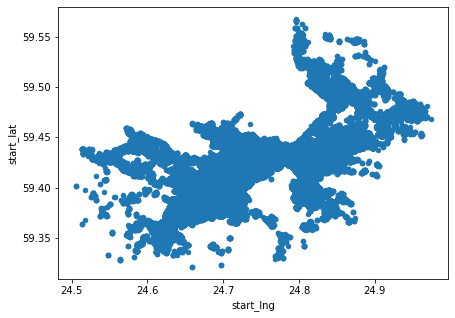

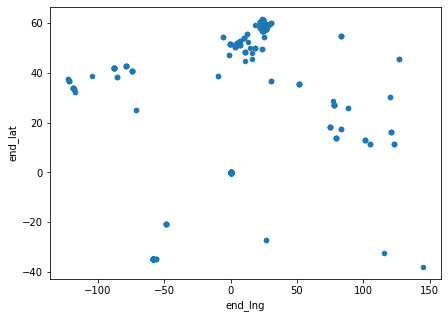

In [482]:
# the second plot shows the destinations are limited areas
B_data.plot(kind='scatter',y='start_lat',x='start_lng',figsize=(7,5))
B_data.plot(kind='scatter',y='end_lat',x='end_lng',figsize=(7,5))

In [759]:
# LSTM solutions: 
# we start from B_3_2022_fill when we fill the missing bins
np.array(B_3_2022_fill).shape

(178560,)

In [760]:
B_3_2022_frame.head()

,start_lat,start_lng,end_lat,end_lng,ride_value,start_time,trip_distance,start_cluster,start_bins
0,59.407910,24.689836,59.513027,24.831630,3.51825,1.646572e+09,0.176508,1,810
1,59.441650,24.762712,59.426450,24.783076,0.50750,1.646904e+09,0.025411,31,1363
2,59.435404,24.749795,59.431901,24.761588,0.19025,1.646569e+09,0.012302,0,806
3,59.406920,24.659006,59.381093,24.641652,0.75600,1.646292e+09,0.031116,15,343
4,59.434940,24.753641,59.489203,24.876170,2.27100,1.646518e+09,0.134007,0,721


In [764]:
# here I start to make two coulumns of start_cluster and start_bin in order to add to the new dataframe
# I wnat to work with from now on named bf
start_cluster=[]
start_bin=[]
for i in range(0,40):
    start_cluster.extend([i]*4464)  
    start_bin.extend([j for j in range(4464)])
# np.array(start_bin).shape
# pd.DataFrame(start_bin).head()

In [784]:
bf=pd.DataFrame(B_3_2022_fill)
bf.columns=['start_demand']
bf['start_bin']=start_bin
bf['start_cluster']=start_cluster
bf.head()
# bf.shape
# print(bf[bf['start_cluster']==1])

,start_demand,start_bin,start_cluster
0,24,0,0
1,40,1,0
2,39,2,0
3,32,3,0
4,34,4,0


In [785]:
# converting to pivot table
pivot = pd.pivot_table(bf, values='start_demand', index='start_bin',columns=['start_cluster'])#, 
print(pivot.shape)
pivot.head()

(4464, 40)


start_cluster,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
start_bin,,,,,,,,,,,,,,,,,,,,,
0,24,2,1,2,0,2,4,4,1,0,...,2,8,0,3,0,3,4,4,1,0
1,40,7,0,1,0,3,4,5,2,4,...,5,11,0,1,0,1,6,3,0,0
2,39,1,2,1,1,5,1,2,0,1,...,0,5,1,2,0,4,3,2,0,0
3,32,2,1,2,1,1,2,1,0,1,...,0,4,1,1,0,1,3,2,0,0
4,34,2,3,0,0,0,3,2,0,1,...,2,3,0,0,0,1,3,0,0,0


In [769]:
# split a multivariate sequence into samples
# window_size = 5
def split_sequences(sequences, window_size):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [813]:
window_size = 5
dataset = np.array(pivot)
# making the dataset
X, y = split_sequences(dataset,window_size)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

print(n_features,X.shape)

40 (4459, 5, 40)


In [812]:
# split into train and validating
split_time = 1337
train_val_X, train_val_y = X[:-split_time, :], y[:-split_time,:]
test_X, test_y = X[-split_time:, :], y[-split_time:,:]
print(train_val_X.shape,test_X.shape)

(3122, 5, 40) (1337, 5, 40)


In [814]:
# define model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential()
model.add(LSTM(40, activation='relu', return_sequences=True, input_shape=(window_size, n_features),recurrent_dropout=0.2))
model.add(LSTM(40, activation='relu',return_sequences=False,recurrent_dropout=0.2))
# model.add(LSTM(256, activation='relu',return_sequences=True,recurrent_dropout=0.1))
# model.add(LSTM(128, activation='relu',recurrent_dropout=0.1))
model.add(Dense(n_features))

In [656]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 12, 40)            12960     
_________________________________________________________________
lstm_13 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dense_74 (Dense)             (None, 40)                1640      
Total params: 27,560
Trainable params: 27,560
Non-trainable params: 0
_________________________________________________________________


In [3]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss="mae", optimizer=optimizer)
history = model.fit(train_val_X, train_val_y,epochs=100, callbacks=[lr_schedule], verbose=0)#

NameError: name 'tf' is not defined

(1e-05, 1.0, 0.0, 6.0)

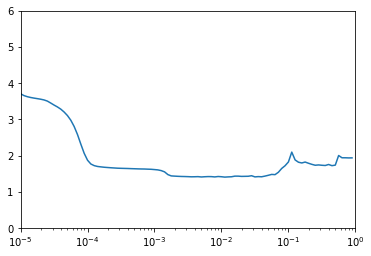

In [795]:
lrs = 1e-5 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-5, 1, 0, 6])

In [815]:
from callbacks import all_callbacks
train = True
if train:
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model')
    history = model.fit(train_val_X, train_val_y, batch_size=10,
              epochs=100, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    model.save('best_model.h5')
else:
    from tensorflow.keras.models import load_model
    model = load_model('best_model.h5')

Epoch 1/100
235/235 [==============================] - 15s 42ms/step - loss: 1.5352 - mae: 1.9508 - val_loss: 1.4049 - val_mae: 1.8242

***callbacks***
saving losses to model\losses.log

Epoch 00001: val_loss improved from inf to 1.40490, saving model to model\KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.40490, saving model to model\KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model\KERAS_check_model_last.h5

Epoch 00001: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 2/100
235/235 [==============================] - 2s 9ms/step - loss: 1.1719 - mae: 1.5828 - val_loss: 1.3393 - val_mae: 1.7623

***callbacks***
saving losses to model\losses.log

Epoch 00002: val_loss improved from 1.40490 to 1.33935, saving model to model\KERAS_check_best_model.h5

Epoch 00002: val_loss improved from 1.40490 to 1.33935, saving model to model\KERAS_check_best_model_weights.h5

Epoch 00002: saving model to model\KERAS_check_

235/235 [==============================] - 3s 14ms/step - loss: 1.0579 - mae: 1.4644 - val_loss: 1.2152 - val_mae: 1.6293

***callbacks***
saving losses to model\losses.log

Epoch 00017: val_loss did not improve from 1.19774

Epoch 00017: val_loss did not improve from 1.19774

Epoch 00017: saving model to model\KERAS_check_model_last.h5

Epoch 00017: saving model to model\KERAS_check_model_last_weights.h5

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.

***callbacks end***

Epoch 18/100
235/235 [==============================] - 3s 14ms/step - loss: 1.0401 - mae: 1.4462 - val_loss: 1.1812 - val_mae: 1.5948

***callbacks***
saving losses to model\losses.log

Epoch 00018: val_loss improved from 1.19774 to 1.18117, saving model to model\KERAS_check_best_model.h5

Epoch 00018: val_loss improved from 1.19774 to 1.18117, saving model to model\KERAS_check_best_model_weights.h5

Epoch 00018: saving model to model\KERAS_check_model_last.h5

Epoch 00018: saving mo

235/235 [==============================] - 3s 13ms/step - loss: 1.0060 - mae: 1.4112 - val_loss: 1.1733 - val_mae: 1.5867

***callbacks***
saving losses to model\losses.log

Epoch 00051: val_loss improved from 1.17469 to 1.17325, saving model to model\KERAS_check_best_model.h5

Epoch 00051: val_loss improved from 1.17469 to 1.17325, saving model to model\KERAS_check_best_model_weights.h5

Epoch 00051: saving model to model\KERAS_check_model_last.h5

Epoch 00051: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 52/100
235/235 [==============================] - 3s 14ms/step - loss: 1.0097 - mae: 1.4150 - val_loss: 1.1759 - val_mae: 1.5898

***callbacks***
saving losses to model\losses.log

Epoch 00052: val_loss did not improve from 1.17325

Epoch 00052: val_loss did not improve from 1.17325

Epoch 00052: saving model to model\KERAS_check_model_last.h5

Epoch 00052: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 53/10

235/235 [==============================] - 3s 13ms/step - loss: 0.9958 - mae: 1.4004 - val_loss: 1.1784 - val_mae: 1.5916

***callbacks***
saving losses to model\losses.log

Epoch 00069: val_loss did not improve from 1.17231

Epoch 00069: val_loss did not improve from 1.17231

Epoch 00069: saving model to model\KERAS_check_model_last.h5

Epoch 00069: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 70/100
235/235 [==============================] - 3s 14ms/step - loss: 0.9972 - mae: 1.4016 - val_loss: 1.1753 - val_mae: 1.5882

***callbacks***
saving losses to model\losses.log

Epoch 00070: val_loss did not improve from 1.17231

Epoch 00070: val_loss did not improve from 1.17231

Epoch 00070: saving model to model\KERAS_check_model_last.h5

Epoch 00070: saving model to model\KERAS_check_model_last_weights.h5

Epoch 00070: saving model to model\KERAS_check_model_epoch70.h5

***callbacks end***

Epoch 71/100
235/235 [==============================] - 3s 1

Epoch 87/100
235/235 [==============================] - 3s 11ms/step - loss: 0.9908 - mae: 1.3951 - val_loss: 1.1765 - val_mae: 1.5895

***callbacks***
saving losses to model\losses.log

Epoch 00087: val_loss did not improve from 1.17231

Epoch 00087: val_loss did not improve from 1.17231

Epoch 00087: saving model to model\KERAS_check_model_last.h5

Epoch 00087: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 88/100
235/235 [==============================] - 3s 15ms/step - loss: 0.9902 - mae: 1.3946 - val_loss: 1.1783 - val_mae: 1.5909

***callbacks***
saving losses to model\losses.log

Epoch 00088: val_loss did not improve from 1.17231

Epoch 00088: val_loss did not improve from 1.17231

Epoch 00088: saving model to model\KERAS_check_model_last.h5

Epoch 00088: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 89/100
235/235 [==============================] - 3s 13ms/step - loss: 0.9906 - mae: 1.3948 - val_loss: 1.

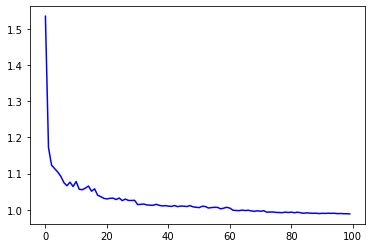

In [816]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

# loss = history.history['val_loss']
# epochs = range(len(loss))
# plt.plot(epochs, loss, 'r', label='Validation Loss')
plt.show()

In [817]:
# demonstrate prediction
train_yhat = model.predict(train_val_X, verbose=0)
print("MAPE of training data : %.3f" % (mean_absolute_error(train_val_y,train_yhat) /(sum(tsne_train_output)/len(tsne_train_output))))

MAPE of training data : 0.387


In [818]:
# demonstrate prediction
test_yhat = model.predict(test_X, verbose=0)
print("MAPE of testing data : %.3f" % (mean_absolute_error(test_y,test_yhat) /(sum(tsne_train_output)/len(tsne_train_output))))

MAPE of testing data : 0.334


In [917]:
# we could find the region with max demands for a specifc time bin
argmax_region=pd.DataFrame(test_yhat)
argmax_region.tail()
ar=np.array(argmax_region)
# ar.shape
print(ar[0,:])
print(np.argmax(ar[0,:]))

[10.935893    4.5966654   2.5730643   2.0452454   1.380989    4.877236
  4.3571258   5.5612526   0.2807138   1.464113    4.66675     1.3092182
  0.68389815  1.8209395   4.9512587   2.451589    2.0887876   1.6427181
  2.0085392   3.6641006   1.0116572   1.1231172   3.6165204   0.639167
  0.74171185  7.755475    8.747362    2.9810777   1.9562083   0.37662816
  3.0635748  11.159128    2.3633971   3.1088548   0.21749711  5.4050674
  5.2179146   3.7685175   0.45956182  0.3752908 ]
31


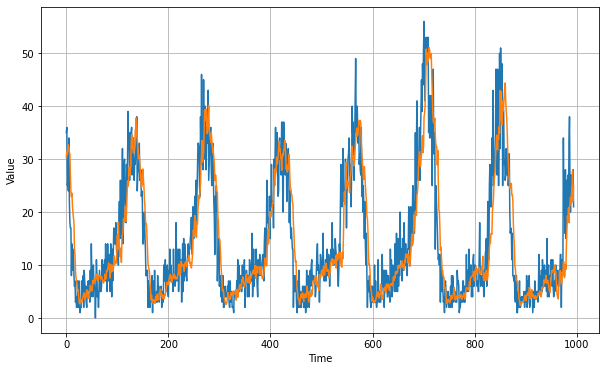

In [859]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
window_size =5
# split_time =5
n=1000
time_valid = np.arange(n-window_size, dtype="float32")    #4464
forecast = []
series=train_val_X#sequences
x_valid=output[0][window_size:n] #4464

for time in range(n-window_size): #len(series) - window_size
    forecast.append(model.predict(series[time:time + window_size][:]))



# 
# forecast = forecast[ n-window_size:]
# print(forecast)
# results = np.array(forecast)
results = np.array(forecast)[:, 0, 0]
# print(np.array(forecast).shape)
# print(forecast)

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
# try another model
# we can try with different hyperparameters (winow_size,LSTM neurons,layers,)

In [884]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, n_features]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
  tf.keras.layers.Dense(n_features)])

In [898]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 32)             6432      
_________________________________________________________________
bidirectional (Bidirectional (None, 5, 64)             16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 40)                2600      
Total params: 50,504
Trainable params: 50,504
Non-trainable params: 0
_________________________________________________________________


In [890]:
epoch = 100
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="mae", optimizer=optimizer)
history = model.fit(train_val_X, train_val_y,epochs=epoch, callbacks=[lr_schedule], verbose=0)#

(0.0001, 1.0, 0.0, 6.0)

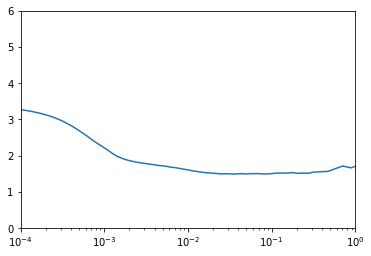

In [893]:
lrs = 1e-4 * (10 ** (np.arange(epoch) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-4, 1, 0, 6])

In [894]:
from callbacks import all_callbacks
train = True
if train:
    optimizer = tf.keras.optimizers.SGD(learning_rate=5e-2, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
    callbacks = all_callbacks(stop_patience = 1000,
                              lr_factor = 0.5,
                              lr_patience = 10,
                              lr_epsilon = 0.000001,
                              lr_cooldown = 2,
                              lr_minimum = 0.0000001,
                              outputDir = 'model')
    history = model.fit(train_val_X, train_val_y, batch_size=10,
              epochs=epoch, validation_split=0.25, shuffle=True,
              callbacks = callbacks.callbacks)
    model.save('best_model.h5')
else:
    from tensorflow.keras.models import load_model
    model = load_model('best_model.h5')

Epoch 1/100
235/235 [==============================] - 45s 152ms/step - loss: 1.5954 - mae: 2.0211 - val_loss: 1.8082 - val_mae: 2.2363

***callbacks***
saving losses to model\losses.log

Epoch 00001: val_loss improved from inf to 1.80824, saving model to model\KERAS_check_best_model.h5

Epoch 00001: val_loss improved from inf to 1.80824, saving model to model\KERAS_check_best_model_weights.h5

Epoch 00001: saving model to model\KERAS_check_model_last.h5

Epoch 00001: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 2/100
235/235 [==============================] - 3s 14ms/step - loss: 1.5720 - mae: 1.9964 - val_loss: 1.8150 - val_mae: 2.2428

***callbacks***
saving losses to model\losses.log

Epoch 00002: val_loss did not improve from 1.80824

Epoch 00002: val_loss did not improve from 1.80824

Epoch 00002: saving model to model\KERAS_check_model_last.h5

Epoch 00002: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 

235/235 [==============================] - 3s 13ms/step - loss: 1.5709 - mae: 1.9953 - val_loss: 1.8189 - val_mae: 2.2470

***callbacks***
saving losses to model\losses.log

Epoch 00018: val_loss did not improve from 1.80824

Epoch 00018: val_loss did not improve from 1.80824

Epoch 00018: saving model to model\KERAS_check_model_last.h5

Epoch 00018: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 19/100
235/235 [==============================] - 3s 14ms/step - loss: 1.5709 - mae: 1.9954 - val_loss: 1.8164 - val_mae: 2.2450

***callbacks***
saving losses to model\losses.log

Epoch 00019: val_loss did not improve from 1.80824

Epoch 00019: val_loss did not improve from 1.80824

Epoch 00019: saving model to model\KERAS_check_model_last.h5

Epoch 00019: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 20/100
235/235 [==============================] - 2s 7ms/step - loss: 1.5708 - mae: 1.9958 - val_loss: 1.8180 - val_mae

235/235 [==============================] - 3s 11ms/step - loss: 1.5706 - mae: 1.9949 - val_loss: 1.8179 - val_mae: 2.2460

***callbacks***
saving losses to model\losses.log

Epoch 00036: val_loss did not improve from 1.80824

Epoch 00036: val_loss did not improve from 1.80824

Epoch 00036: saving model to model\KERAS_check_model_last.h5

Epoch 00036: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 37/100
235/235 [==============================] - 3s 13ms/step - loss: 1.5706 - mae: 1.9952 - val_loss: 1.8177 - val_mae: 2.2458

***callbacks***
saving losses to model\losses.log

Epoch 00037: val_loss did not improve from 1.80824

Epoch 00037: val_loss did not improve from 1.80824

Epoch 00037: saving model to model\KERAS_check_model_last.h5

Epoch 00037: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 38/100
235/235 [==============================] - 3s 13ms/step - loss: 1.5706 - mae: 1.9951 - val_loss: 1.8175 - val_ma

235/235 [==============================] - 3s 14ms/step - loss: 1.5705 - mae: 1.9949 - val_loss: 1.8178 - val_mae: 2.2459

***callbacks***
saving losses to model\losses.log

Epoch 00054: val_loss did not improve from 1.80824

Epoch 00054: val_loss did not improve from 1.80824

Epoch 00054: saving model to model\KERAS_check_model_last.h5

Epoch 00054: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 55/100
235/235 [==============================] - 4s 16ms/step - loss: 1.5705 - mae: 1.9950 - val_loss: 1.8177 - val_mae: 2.2459

***callbacks***
saving losses to model\losses.log

Epoch 00055: val_loss did not improve from 1.80824

Epoch 00055: val_loss did not improve from 1.80824

Epoch 00055: saving model to model\KERAS_check_model_last.h5

Epoch 00055: saving model to model\KERAS_check_model_last_weights.h5

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0015625000232830644.

***callbacks end***

Epoch 56/100
235/235 [======================

235/235 [==============================] - 3s 13ms/step - loss: 1.5705 - mae: 1.9949 - val_loss: 1.8175 - val_mae: 2.2457

***callbacks***
saving losses to model\losses.log

Epoch 00072: val_loss did not improve from 1.80824

Epoch 00072: val_loss did not improve from 1.80824

Epoch 00072: saving model to model\KERAS_check_model_last.h5

Epoch 00072: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 73/100
235/235 [==============================] - 3s 13ms/step - loss: 1.5705 - mae: 1.9949 - val_loss: 1.8175 - val_mae: 2.2456

***callbacks***
saving losses to model\losses.log

Epoch 00073: val_loss did not improve from 1.80824

Epoch 00073: val_loss did not improve from 1.80824

Epoch 00073: saving model to model\KERAS_check_model_last.h5

Epoch 00073: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 74/100
235/235 [==============================] - 3s 13ms/step - loss: 1.5705 - mae: 1.9949 - val_loss: 1.8175 - val_ma

235/235 [==============================] - 4s 17ms/step - loss: 1.5705 - mae: 1.9949 - val_loss: 1.8175 - val_mae: 2.2456

***callbacks***
saving losses to model\losses.log

Epoch 00090: val_loss did not improve from 1.80824

Epoch 00090: val_loss did not improve from 1.80824

Epoch 00090: saving model to model\KERAS_check_model_last.h5

Epoch 00090: saving model to model\KERAS_check_model_last_weights.h5

Epoch 00090: saving model to model\KERAS_check_model_epoch90.h5

***callbacks end***

Epoch 91/100
235/235 [==============================] - 3s 14ms/step - loss: 1.5705 - mae: 1.9949 - val_loss: 1.8174 - val_mae: 2.2456

***callbacks***
saving losses to model\losses.log

Epoch 00091: val_loss did not improve from 1.80824

Epoch 00091: val_loss did not improve from 1.80824

Epoch 00091: saving model to model\KERAS_check_model_last.h5

Epoch 00091: saving model to model\KERAS_check_model_last_weights.h5

***callbacks end***

Epoch 92/100
235/235 [==============================] - 3s 1

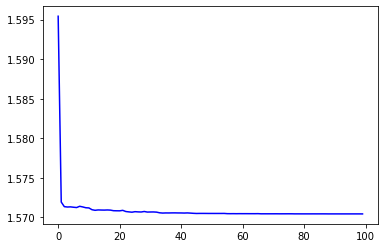

In [895]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

# loss = history.history['val_loss']
# epochs = range(len(loss))
# plt.plot(epochs, loss, 'r', label='Validation Loss')
plt.show()

In [896]:
# demonstrate prediction
train_yhat = model.predict(train_val_X, verbose=0)
print("MAPE of training data : %.3f" % (mean_absolute_error(train_val_y,train_yhat) /(sum(tsne_train_output)/len(tsne_train_output))))

MAPE of training data : 0.553


In [897]:
# demonstrate prediction
test_yhat = model.predict(test_X, verbose=0)
print("MAPE of testing data : %.3f" % (mean_absolute_error(test_y,test_yhat) /(sum(tsne_train_output)/len(tsne_train_output))))

MAPE of testing data : 0.728


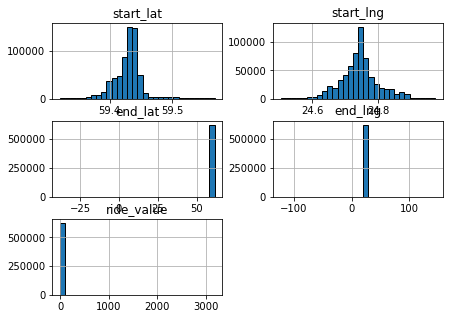

In [489]:
# From histograms, we can see the distribution of the data and outliers
B.describe()
B_data.hist(figsize=(7, 5), bins=30, edgecolor="black")
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix
features_of_interest = ['start_time', 'start_lat', 'start_lng', 'end_lat', 'end_lng','ride_value']
scatter_matrix(B[features_of_interest], marker='O', figsize=(12, 10));

In [ ]:
# In the end, I thought the question is for the highet demands and I solved based on the assumption, 
# # for the highest ride values, the changes considering summation of the ride_values per region over time bins
# # # instead of the highest demands
